# Autoencoder를 이용한 시계열 이상 감지

이 스크립트는 재구성 컨볼루션 오토인코더(reconstruction convolutional autoencoder) 모델을 사용하여 시계열 데이터의 이상(anomaly)을 감지하는 방법을 보여줍니다.

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data

[Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) (Dataset and scoring for detecting anomalies in streaming data) 데이터 세트를 사용합니다. 이 데이터세트는 레이블이 지정된 비정상적인 동작 기간이 포함된 인공 시계열 데이터를 제공합니다. 데이터는 순서가 있는 타임스탬프가 지정된 단일 값 메트릭입니다.

훈련에는 `anomaly가 없는` `art_daily_small_noise.csv` 파일을 사용하고 테스트에는 `인공 anomaly가 있는` `art_daily_jumpsup.csv` 파일을 사용합니다. 이 데이터 세트의 단순성 덕분에 이상 탐지를 효과적으로 시연할 수 있습니다.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"

#for train - anomaly 가 없는 data
df_small_noise_url = master_url_root + noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

# for test - 인공 anomaly 가 있는 data
df_daily_jumpsup_url = master_url_root + jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

print(df_small_noise.shape)
print(df_daily_jumpsup.shape)

(4032, 1)
(4032, 1)


In [3]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [4]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## data 시각화
### 이상이 없는 시계열 데이터
훈련을 위해 다음 데이터를 사용할 것입니다.

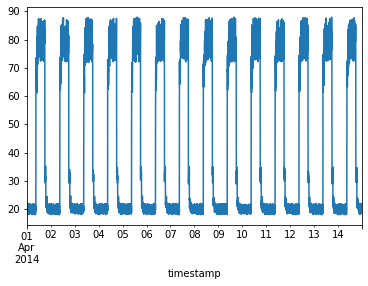

In [5]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### 이상이 있는 시계열 데이터
테스트를 위해 다음 데이터를 사용하고 데이터의 갑작스러운 점프가 이상으로 감지되는지 확인합니다.

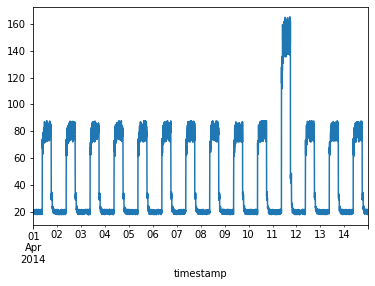

In [6]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## 훈련 데이터 준비

훈련 시계열 데이터 파일에서 데이터 값을 가져오고 '값' 데이터를 정규화합니다. 14일 동안 5분마다 '값'이 있습니다.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = total **4032 data points** 

In [7]:
# Standard scaling
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

df_training_scaled = (df_small_noise - training_mean) / training_std

### 시퀀스 생성
훈련 데이터에서 'TIME_STEPS' 연속 데이터 값을 결합하여 시퀀스를 생성했습니다.

In [8]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.array(output)

x_train = create_sequences(df_training_scaled)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


## Build a model

convolutional reconstruction autoencoder model을 구축합니다. 모델은 `(batch_size, sequence_length, num_features)` shape의 입력을 받고 동일한 shape의 출력을 반환합니다. 이 경우 `sequence_length`는 288이고 `num_features`는 1입니다.

In [9]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the model

재구성 모델이기 때문에 입력과 대상 모두로 `x_train`을 사용하고 있습니다.

In [10]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 33ms/step - loss: 0.6990 - val_loss: 0.4684
Epoch 2/50
27/27 [==============================] - 1s 29ms/step - loss: 0.1763 - val_loss: 0.0701
Epoch 3/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0606 - val_loss: 0.0420
Epoch 4/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0482 - val_loss: 0.0353
Epoch 5/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0416 - val_loss: 0.0328
Epoch 6/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0374 - val_loss: 0.0313
Epoch 7/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0341 - val_loss: 0.0299
Epoch 8/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0314 - val_loss: 0.0280
Epoch 9/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0291 - val_loss: 0.0273
Epoch 10/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0271 - val_loss: 0.0260
Epoch 11/

훈련이 어떻게 진행되었는지 보기 위해 훈련 및 검증 손실을 플롯해 보겠습니다.

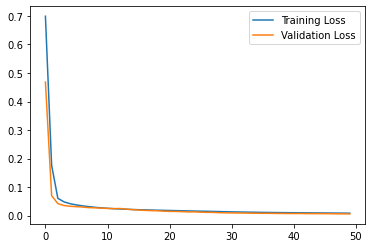

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

모델이 입력 데이터를 얼마나 잘 재구성할 수 있는지 결정하여 이상을 감지합니다.

1. 훈련 샘플에서 MAE loss를 찾습니다.
2. 최대 MAE loss 값을 찾습니다. 이것은 우리 모델이 샘플을 재구성하기 위해 수행한 최악의 작업입니다. 우리는 이것을 이상 감지에 대한 '임계값'으로 정합니다.  
3. 샘플의 재구성 손실이 이 '임계값' 값보다 크면 모델이 익숙하지 않은 패턴을 보고 있다고 추론할 수 있습니다. 우리는 이 샘플을 '이상(anomaly)'으로 분류할 것입니다.


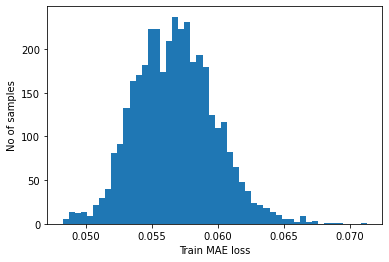

Reconstruction error threshold:  0.07131244164634068


In [12]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

우리 모델이 첫 번째 샘플을 어떻게 재구성했는지 시각화해 봅니다.
이것은 train dataset day 1 으로 부터  288개 timestep 입니다.

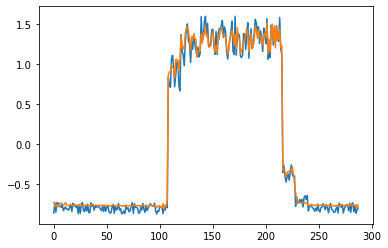

In [13]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

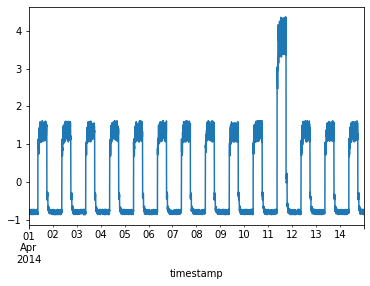

In [14]:
# test data 정규화
df_test_scaled = (df_daily_jumpsup - training_mean) / training_std

fig, ax = plt.subplots()
df_test_scaled.plot(legend=False, ax=ax)
plt.show()

In [15]:
# Create sequences from test values.
x_test = create_sequences(df_test_scaled.values)

print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


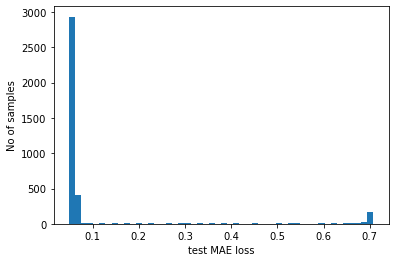

In [16]:
# test MAE loss 계산 및 시각화
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [17]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  402
Indices of anomaly samples:  (array([1654, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
       2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2

## Plot anomalies

이제 우리는 비정상 데이터 샘플을 알고 있습니다. 이를 통해 원본 테스트 데이터에서 해당 '타임스탬프'를 찾을 수 있습니다. 이를 위해 다음 방법을 사용할 것입니다.

time_steps = 3이고 10개의 훈련 값이 있다고 가정해 보겠습니다. 우리의 `x_train`은 다음과 같이 보일 것입니다:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

초기 및 최종 time_steps-1 데이터 값을 제외한 모든 값은 'time_steps' 샘플 수로 표시됩니다. 따라서 샘플 [(3, 4, 5), (4, 5, 6), (5, 6, 7)]이 비정상임을 안다면 데이터 포인트 5가 비정상이라고 말할 수 있습니다.

In [18]:
TIME_STEPS - 1, len(df_test_scaled) - TIME_STEPS + 1

(287, 3745)

In [19]:
for data_idx in range(TIME_STEPS - 1, len(df_test_scaled) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        print(data_idx)
        print(data_idx - TIME_STEPS + 1, data_idx)
        break
    

2988
2701 2988


In [20]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_scaled) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):  #all True
        anomalous_data_indices.append(data_idx)

In [21]:
len(anomalous_data_indices)

115

원본 테스트 데이터 플롯에 이상 현상을 오버레이해 보겠습니다.

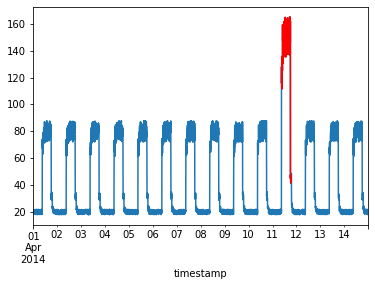

In [22]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()